## Downloading libraries & checking ressources

In [1]:
!pip install stop-words
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.8 MB/s eta 0:00:00


In [2]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

24

# Data Analysis

## 1- Importing libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk import ngrams
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 2- Vizualisation

In [4]:
from google.colab import files
import zipfile
import pandas as pd
import os

# 1️⃣ Upload du zip
print("⬆️ Upload datasets.zip depuis ton PC")
uploaded = files.upload()  # sélectionner datasets.zip

# 2️⃣ Dézipper
zip_filename = list(uploaded.keys())[0]
extract_dir = "datasets"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extraction terminée dans : {extract_dir}")

# 3️⃣ Charger les fichiers CSV
human_path = os.path.join(extract_dir, "human_dataset.csv")
ai_path = os.path.join(extract_dir, "Ai_dataset.csv")

⬆️ Upload datasets.zip depuis ton PC


Saving datasets.zip to datasets (1).zip
✅ Extraction terminée dans : datasets


In [5]:
human_path = os.path.join(extract_dir, "human_dataset.csv")
ai_path = os.path.join(extract_dir, "Ai_dataset.csv")

data_human = pd.read_csv(human_path)
data_ai = pd.read_csv(ai_path)

# 4️⃣ Fusionner en un seul DataFrame
data = pd.concat([data_human, data_ai], ignore_index=True)

print(f"📊 Dataset fusionné : {data.shape[0]} lignes, {data.shape[1]} colonnes")
print("🔍 Aperçu :")

📊 Dataset fusionné : 95395 lignes, 2 colonnes
🔍 Aperçu :


In [6]:
data.head()

,text,label
0,"'Basically there are many categories of "" Best...",human
1,'salt is good for not dying in car crashes and...,human
2,"""The way it works is that old TV stations got ...",human
3,"""You ca n't just go around assassinating the l...",human
4,'Wanting to kill the shit out of Germans drive...,human


In [7]:
data.tail()

,text,label
95390,"Well, to be honest, it's kind of complicated h...",Ai
95391,The prevalence of draws in chess among the top...,Ai
95392,"So, you know how when you're driving with your...",Ai
95393,Nightmares are disturbing and distressing drea...,Ai
95394,The negative perception of Gypsies or Roma peo...,Ai


In [8]:
print("===================================")
print("the data length : ", data.shape[0], "\n")
print("the data number of columns : ", data.shape[1], "\n")

print("===================================")
print("data columns : ", data.columns, "\n")


print("===================================")
print("data informations : \n")
data.info()


print("===================================")
print("data description : ")
data.describe()

the data length :  95395 

the data number of columns :  2 

data columns :  Index(['text', 'label'], dtype='object') 

data informations : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95395 entries, 0 to 95394
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    95395 non-null  object
 1   label   95395 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
data description : 


,text,label
count,95395,95395
unique,95395,2
top,The negative perception of Gypsies or Roma peo...,Ai
freq,1,47796


In [9]:
print("Number of null values in the dataset:")
data.isnull().sum()

Number of null values in the dataset:


,0
text,0
label,0


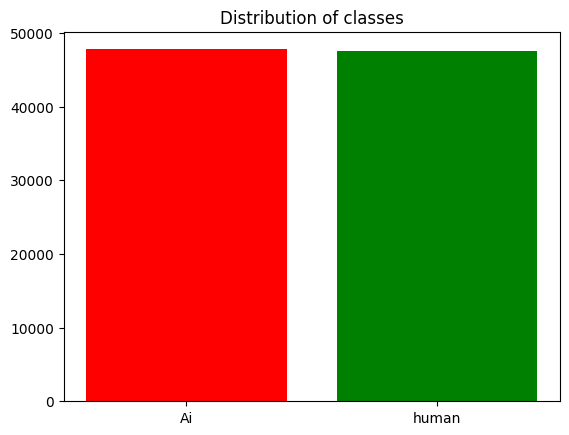

In [10]:
# visualization data distribution

plt.bar(['Ai' , 'human'], data['label'].value_counts(), color=['red', 'green'])
plt.title('Distribution of classes')
plt.show()

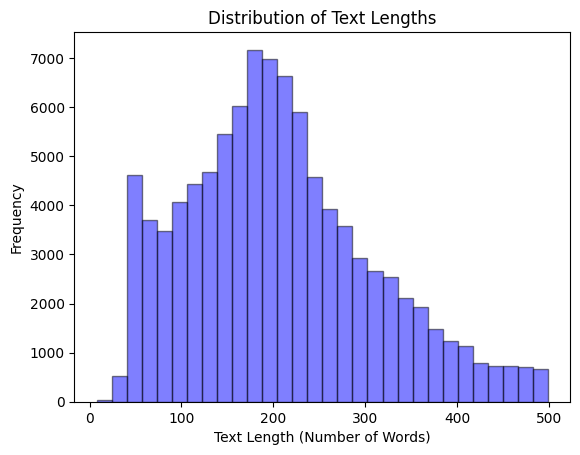

In [11]:
# visualization of comment length distribution

data['text_length'] = data['text'].apply(lambda x: len(x.split()))

plt.hist(data['text_length'], bins=30, color='blue', edgecolor='black', alpha=0.5)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

- we can see that we have some texts that have less than 50 words which is not we want
- we want texts that are ranging between 50 and 500 words only so we will be removing texts that are less than 50 word

In [12]:
count = (data['text_length'] < 50).sum()
print(f"number of rows with less than 50 words: {count}")

data.drop(data[data['text_length'] < 50].index, inplace=True)

count = (data['text_length'] < 50).sum()
print(f"number of rows with less than 50 words after the removal: {count}")



number of rows with less than 50 words: 2988
number of rows with less than 50 words after the removal: 0


/tmp/ipython-input-2409304865.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_text_length.index, y=average_text_length.values, palette=['red', 'green'])


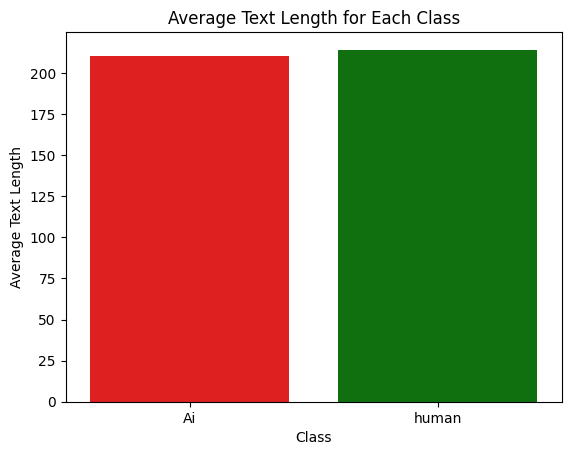

In [13]:
average_text_length = data.groupby('label')['text_length'].mean()

sns.barplot(x=average_text_length.index, y=average_text_length.values, palette=['red', 'green'])
plt.title('Average Text Length for Each Class')
plt.xlabel('Class')
plt.ylabel('Average Text Length')
plt.show()

# Data Cleaning

In [14]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from stop_words import get_stop_words
from nltk.corpus import stopwords
from contractions import fix
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## 1- Noise cleaning

in this section we will be :

- Removing HTML tags
- Removing Urls
- Removing Email Addresses
- Removing Hashtags
- Removing Mentions (@username)
- Removing Non English Characters (Including Emoji's )


In [15]:
def remove_html_tags(text):
  """
    removes html tags.
  """
  cleaned_text = re.sub(r'<.*?>', ' ', text)
  return cleaned_text

In [16]:
def remove_urls(text):
    """
      removes urls.
    """
    cleaned_text = re.sub(r'\b(?:http|https|www)\S+', ' ', text, flags=re.IGNORECASE)
    return cleaned_text

In [17]:
def remove_emails(text):
    """
      removes emails.
    """
    cleaned_text = re.sub(r'\S+@\S+', ' ', text)
    return cleaned_text


In [18]:
def remove_mentions(text):
    """
      removes mentions.
    """
    cleaned_text = re.sub(r'@\w+', ' ', text)
    return cleaned_text

In [19]:
def remove_hashtags(text):
    """
      removes hashtags.
    """
    cleaned_text = re.sub(r'#\w+', ' ', text)
    return cleaned_text

In [20]:
def remove_none_english_characters(text):
    """
      removes none english characters & emojis & ponctuation.
    """
    cleaned_text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    return cleaned_text

In [21]:
def noise_cleaning(text):
  """
    performs noise cleaning on text.
  """
  cleaned_text = remove_html_tags(text)
  cleaned_text = remove_urls(cleaned_text)
  cleaned_text = remove_emails(cleaned_text)
  cleaned_text = remove_mentions(cleaned_text)
  cleaned_text = remove_hashtags(cleaned_text)
  cleaned_text = remove_none_english_characters(cleaned_text)

  return cleaned_text

In [22]:
import time
from joblib import Parallel, delayed
start_time = time.time()

data['cleaned_text'] = Parallel(n_jobs=96)(delayed(noise_cleaning)(text) for text in data['text'])

end_time = time.time()

time_taken = end_time - start_time

print(f"Time taken to clean the text: {time_taken:.4f} seconds")

Time taken to clean the text: 165.6828 seconds


## 2- Standardization

in this section we will be :

- Normalizing ordinals (1st -> 1, 21th -> 21, etc...)
- Expanding Contractions (don't -> do not, isn't -> is not)

---
Normalizing ordinals will lead to better cleaning
because in case we deleted number alone (th, st, nd) will stay in the text and won't be deleted.

---
Same for Contractions they should be expended because is we delelte punctuation words like "isn't" will become "isn t" that won't be removed in the stop words treatment.



In [23]:
def expand_contractions(text):
    """
      expands contractions in the text (don't -> do not)
    """
    return fix(text)

In [24]:
def standardize_ordinal(text):
    """
      standardize ordinal numbers in text.
      from 12th -> 12, 1st -> 1 , etc...
    """
    cleaned_text = re.sub(r'(\d+)(st|nd|rd|th)\b', r'\1', text)
    return cleaned_text

In [25]:
def standardization(text):
  """
    performs standardization on text.
  """
  cleaned_text = standardize_ordinal(text)
  cleaned_text = expand_contractions(cleaned_text)

  return cleaned_text

In [26]:
import time
from joblib import Parallel, delayed
start_time = time.time()

data['cleaned_text'] = Parallel(n_jobs=96)(delayed(standardization)(text) for text in data['cleaned_text'])

end_time = time.time()

time_taken = end_time - start_time

print(f"Time taken to clean the text: {time_taken:.4f} seconds")

Time taken to clean the text: 3.7269 seconds


## 3- Basic text cleaning

in this section we will be :

- Removing Numbers
- Removing Extra Whitespaces And Newlines
- Lowercasing
- remove time suffix (AM and PM)


In [27]:
def remove_numbers(text):
  """
    removes numbers.
  """
  cleaned_text = re.sub(r'\d+', ' ', text)
  return cleaned_text

In [28]:
def remove_newline(text):
  """
    removes newline characters.
  """
  cleaned_text = re.sub(r'\n+', ' ', text)
  return cleaned_text


In [29]:
def remove_duplicated_spaces(text):
  """
    removes duplicated spaces.
  """
  cleaned_text = re.sub(r'\s+',' ', text)
  cleaned_text = cleaned_text.strip()

  return cleaned_text

In [30]:
def lower_case(text):
  """
    converts text to lower case.
  """
  cleaned_text = text.lower()
  return cleaned_text

In [31]:
def remove_punctuation(text):
    """
    Removes punctuation except periods and replaces consecutive periods with a single period.
    """
    translator = str.maketrans('', '', string.punctuation.replace('.', ''))
    cleaned_text = text.translate(translator)

    cleaned_text = re.sub(r'\.{2,}', '', cleaned_text)
    return cleaned_text


text = "hello everyone my name is amy!! #5 ^* ne, hoyaa , idkk. ... but kinda. CoooL"
cleaned_text = remove_punctuation(text)
print(cleaned_text)

hello everyone my name is amy 5  ne hoyaa  idkk.  but kinda. CoooL


In [32]:
def remove_time_formats(text):
  """
    removes time formats am and pm only.
  """
  cleaned_text = re.sub(r'\s(am|pm)\b', '', text)
  return cleaned_text

In [33]:
# this function is used to delete chars that stays alone like if i had a text like this :
# f(x) -> x+y after deleting symbols it will become f x x y which doesn't make sense
def remove_alone_chars(text):
  """
    removes single characters.
  """
  cleaned_text = re.sub(r'\b\w\b', '', text)
  return cleaned_text

In [34]:
def basic_cleaning(text):
  """
    performs basic cleaning on text.
  """

  cleaned_text = remove_numbers(text)
  cleaned_text = remove_newline(cleaned_text)
  cleaned_text = lower_case(cleaned_text)
  cleaned_text = remove_time_formats(cleaned_text)
  cleaned_text = remove_alone_chars(cleaned_text)
  cleaned_text = remove_punctuation(cleaned_text)
  cleaned_text = remove_duplicated_spaces(cleaned_text)


  return cleaned_text


text = "obstruction marker aircraft particularly helicopter see flying . united state required faa advisory circular url . anything high enough need marked tall building red flashing light . also map pilot following pre planned route stay well away news emergency response helicopter pilot especially vulnerable missing thin wire following action ground . small low flying plane helicopter see quote one favorite ... song driver url power line floater airplane wo nt get snagged ."
cleaned_text = basic_cleaning(text)
print(cleaned_text)

obstruction marker aircraft particularly helicopter see flying . united state required faa advisory circular url . anything high enough need marked tall building red flashing light . also map pilot following pre planned route stay well away news emergency response helicopter pilot especially vulnerable missing thin wire following action ground . small low flying plane helicopter see quote one favorite song driver url power line floater airplane wo nt get snagged .


In [35]:
import time
from joblib import Parallel, delayed
start_time = time.time()

data['cleaned_text'] = Parallel(n_jobs=96)(delayed(basic_cleaning)(text) for text in data['cleaned_text'])

end_time = time.time()

time_taken = end_time - start_time

print(f"Time taken to clean the text: {time_taken:.4f} seconds")

Time taken to clean the text: 13.0120 seconds


## 4- Tokenization & Stop Words Removal & Lemmatization


### 4.1- Tokenization

In [36]:
def tokenize(text):
  """
    tokenizes text.
  """
  tokens = word_tokenize(text)
  return tokens

### 4.2- Stop Words

first we will create a set of stop words by combining stop words from nltk, stop_words and sp

In [37]:
stop_words = list(get_stop_words('en'))
nltk_words = list(stopwords.words('english'))

all_stopwords = stop_words + nltk_words
all_stopwords= set(all_stopwords)

len(all_stopwords)

1339

In [38]:
def remove_stop_words(tokens):
  """
    removes stop words from tokens.
  """
  cleaned_tokens = [token for token in tokens if token not in all_stopwords]
  return cleaned_tokens

### 4.3- Lemmatization



In [39]:
def lemmatize_text(tokens):
  """
    lemmatizes tokens.
  """
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  cleaned_text = ' '.join(lemmatized_tokens)
  return cleaned_text

### 4.4- Final Function for Tokenization, Stop Word and Lemmatization

In [40]:
def text_tok_stop_lem(text):
  """
    performs tokenization, stop word removal and lemmatization on text.
  """
  tokens = tokenize(text)
  cleaned_tokens = remove_stop_words(tokens)
  cleaned_text = lemmatize_text(cleaned_tokens)

  return cleaned_text

In [41]:
import time
from joblib import Parallel, delayed
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

start_time = time.time()

data['cleaned_text'] = Parallel(n_jobs=96)(delayed(text_tok_stop_lem)(text) for text in data['cleaned_text'])

end_time = time.time()

time_taken = end_time - start_time

print(f"Time taken to clean the text: {time_taken:.4f} seconds")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken to clean the text: 248.3964 seconds


## 5- Final Data

In [42]:
data.head()

,text,label,text_length,cleaned_text
0,"'Basically there are many categories of "" Best...",human,267,basically category seller . replace seller osc...
1,'salt is good for not dying in car crashes and...,human,417,salt dying car crash car crash worse car salt ...
2,"""The way it works is that old TV stations got ...",human,482,station bandwidth replace analog station . hd ...
3,"""You ca n't just go around assassinating the l...",human,201,assassinating leader country nt international ...
4,'Wanting to kill the shit out of Germans drive...,human,287,kill shit german drive innovation . frequent p...


In [43]:
data.tail()

,text,label,text_length,cleaned_text
95390,"Well, to be honest, it's kind of complicated h...",Ai,213,honest complicated cell tower transmit cellpho...
95391,The prevalence of draws in chess among the top...,Ai,352,prevalence draw chess player attributed multip...
95392,"So, you know how when you're driving with your...",Ai,238,driving mom dad sign road speed limit tell dri...
95393,Nightmares are disturbing and distressing drea...,Ai,302,nightmare disturbing distressing dream produce...
95394,The negative perception of Gypsies or Roma peo...,Ai,244,negative perception gypsy rom people complicat...


In [44]:
# check if classes are balanced

data['label'].value_counts()

,count
label,
Ai,46516
human,45891


- re arrange data so we can drop unecessary columns after

In [45]:
data_arranged = data[["cleaned_text","text_length","label","text"]]
data_arranged.head()

,cleaned_text,text_length,label,text
0,basically category seller . replace seller osc...,267,human,"'Basically there are many categories of "" Best..."
1,salt dying car crash car crash worse car salt ...,417,human,'salt is good for not dying in car crashes and...
2,station bandwidth replace analog station . hd ...,482,human,"""The way it works is that old TV stations got ..."
3,assassinating leader country nt international ...,201,human,"""You ca n't just go around assassinating the l..."
4,kill shit german drive innovation . frequent p...,287,human,'Wanting to kill the shit out of Germans drive...


- dropping unecessary columns from the arranged dataset
- renaming the *''cleaned_text''* column to *'text'*


In [46]:
data_arranged.drop(columns=["text"], inplace=True)
data_arranged.rename(columns={"cleaned_text": "text"}, inplace=True)
print(data_arranged.shape)


(92407, 3)


/tmp/ipython-input-4199725597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arranged.drop(columns=["text"], inplace=True)
/tmp/ipython-input-4199725597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arranged.rename(columns={"cleaned_text": "text"}, inplace=True)


In [47]:
data_arranged.to_csv('cleaned_data.csv', index=False)

# N-gram Analysis

In [48]:
data = pd.read_csv('cleaned_data.csv')

In [49]:
data.head()

,text,text_length,label
0,basically category seller . replace seller osc...,267,human
1,salt dying car crash car crash worse car salt ...,417,human
2,station bandwidth replace analog station . hd ...,482,human
3,assassinating leader country nt international ...,201,human
4,kill shit german drive innovation . frequent p...,287,human


In [50]:
def filter_by_label(df, label):
    return df[df['label'] == label]

In [51]:
def extract_ngrams(text, n):
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    ngrams = list(nltk.ngrams(tokens, n))
    return ngrams

In [52]:
def count_ngrams(texts, n):
    all_ngrams = (ngram for text in texts for ngram in extract_ngrams(text, n))
    return Counter(all_ngrams)

In [53]:
def plot_ngram_frequencies(ngrams_counter, title, n):
    most_common = ngrams_counter.most_common(n)
    ngrams, counts = zip(*most_common)
    ngrams = [' '.join(ngram) for ngram in ngrams]
    plt.barh(ngrams, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('N-grams')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

Number of unique unigrams: 158706


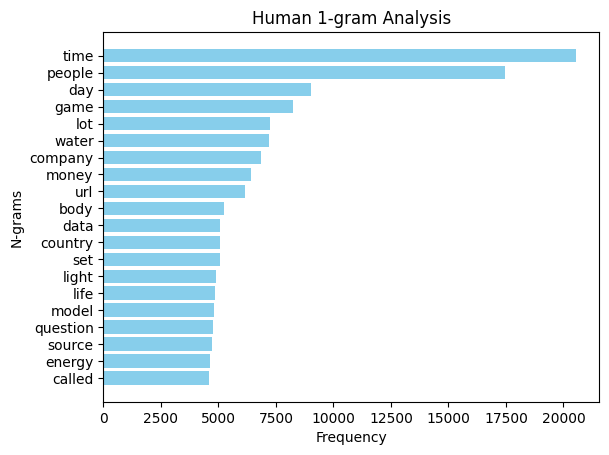

Number of unique bigrams: 2609998


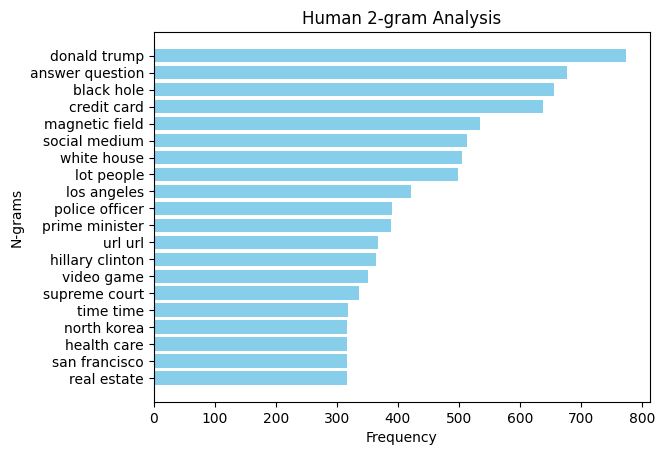

Number of unique trigrams: 2609998


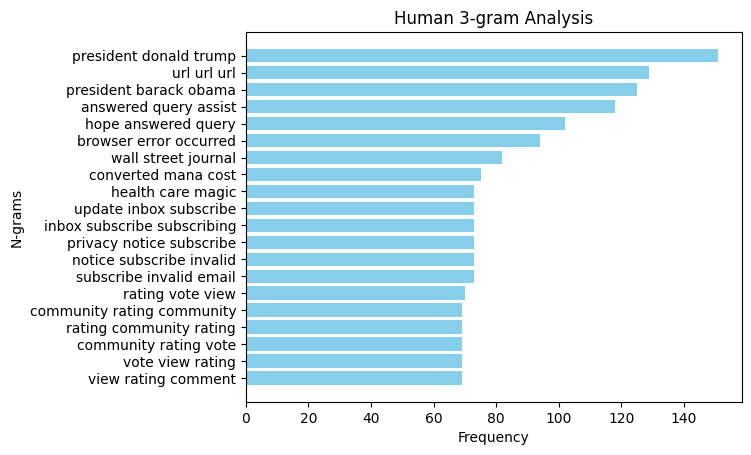

In [54]:
humanDF = filter_by_label(data, "human")


# count number of unique unigrams in human text
uningram_counts = count_ngrams(humanDF['text'], 1)

unique_unigrams = len(uningram_counts)
print(f"Number of unique unigrams: {unique_unigrams}")

plot_ngram_frequencies(uningram_counts, title=f'Human {1}-gram Analysis', n=20)




# count number of unique bigrams in human text
bigram_counts = count_ngrams(humanDF['text'], 2)

unique_bigrams = len(bigram_counts)
print(f"Number of unique bigrams: {unique_bigrams}")

plot_ngram_frequencies(bigram_counts, title=f'Human {2}-gram Analysis', n=20)


#count number of unique trigrams in human text
trigram_counts = count_ngrams(humanDF['text'], 3)

unique_trigrams = len(bigram_counts)
print(f"Number of unique trigrams: {unique_trigrams}")

plot_ngram_frequencies(trigram_counts, title=f'Human {3}-gram Analysis', n=20)

Number of unique unigrams: 103388


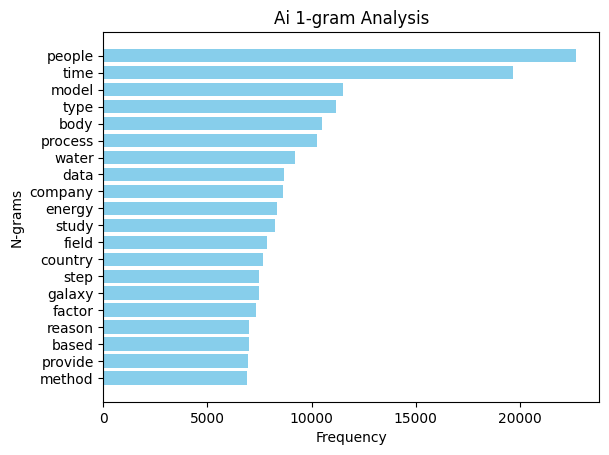

Number of unique bigrams: 1839939


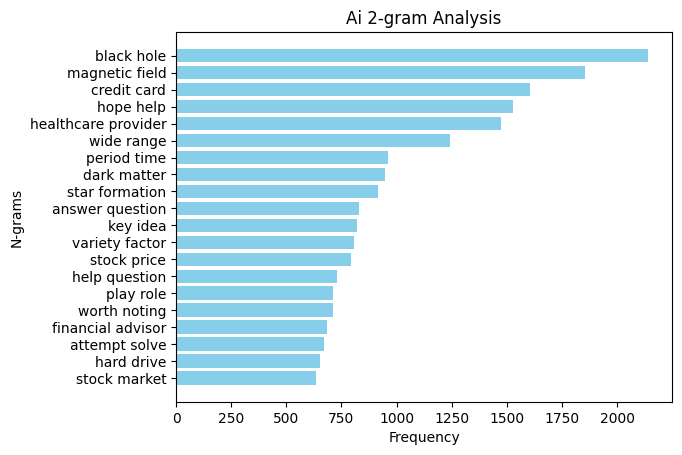

Number of unique trigrams: 1839939


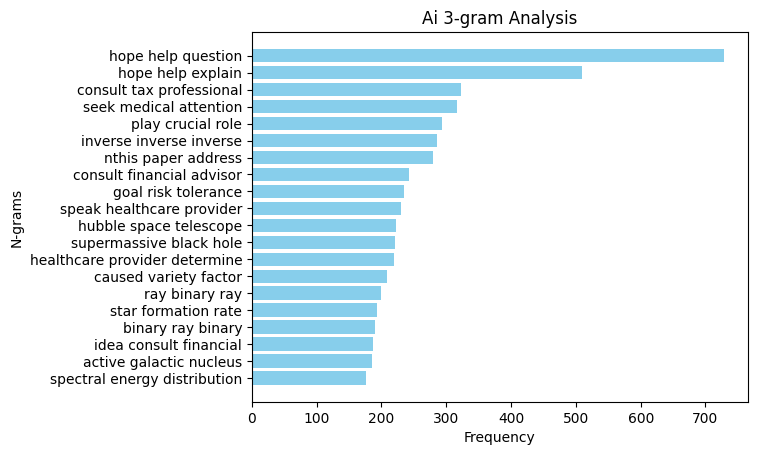

In [55]:
aiDF = filter_by_label(data, "Ai")


# count number of unique unigrams in human text
uningram_counts = count_ngrams(aiDF['text'], 1)

unique_unigrams = len(uningram_counts)
print(f"Number of unique unigrams: {unique_unigrams}")

plot_ngram_frequencies(uningram_counts, title=f'Ai {1}-gram Analysis', n=20)

# count number of unique bigrams in human text
bigram_counts = count_ngrams(aiDF['text'], 2)

unique_bigrams = len(bigram_counts)
print(f"Number of unique bigrams: {unique_bigrams}")

plot_ngram_frequencies(bigram_counts, title=f'Ai {2}-gram Analysis', n=20)

# count number of unique bigrams in human text
trigram_counts = count_ngrams(aiDF['text'], 3)

unique_trigrams = len(bigram_counts)
print(f"Number of unique trigrams: {unique_trigrams}")

plot_ngram_frequencies(trigram_counts, title=f'Ai {3}-gram Analysis', n=20)